In [1]:
%matplotlib inline


# Topic extraction with Non-negative Matrix Factorization and Latent Dirichlet Allocation


This is an example of applying :class:`sklearn.decomposition.NMF` and
:class:`sklearn.decomposition.LatentDirichletAllocation` on a corpus
of documents and extract additive models of the topic structure of the
corpus.  The output is a list of topics, each represented as a list of
terms (weights are not shown).

Non-negative Matrix Factorization is applied with two different objective
functions: the Frobenius norm, and the generalized Kullback-Leibler divergence.
The latter is equivalent to Probabilistic Latent Semantic Indexing.

The default parameters (n_samples / n_features / n_components) should make
the example runnable in a couple of tens of seconds. You can try to
increase the dimensions of the problem, but be aware that the time
complexity is polynomial in NMF. In LDA, the time complexity is
proportional to (n_samples * iterations).




In [3]:
# Author: Olivier Grisel <olivier.grisel@ensta.org>
#         Lars Buitinck
#         Chyi-Kwei Yau <chyikwei.yau@gmail.com>
# License: BSD 3 clause

from __future__ import print_function

import itertools
from pathlib import Path
from time import time
import os

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation

from text_processing.simple import parse_all

n_samples = 20000
n_features = 5000
n_components = 15
n_top_words = 20


def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        message = "Topic #%d: " % topic_idx
        message += " ".join([feature_names[i]
                             for i in topic.argsort()[:-n_top_words - 1:-1]])
        print(message)
    print()


print("Loading dataset...")
t0 = time()
data_samples = list(itertools.islice(parse_all("./out/docs_simple2"), n_samples))
print("loaded %d samples in %0.3fs." % (len(data_samples), time() - t0))

Loading dataset...
loaded 20000 samples in 307.761s.


In [4]:
from collections import defaultdict

from nltk.stem.snowball import SnowballStemmer

import numpy as np


class key_dependent_dict(defaultdict):
    def __init__(self, f_of_x):
        super().__init__(None) # base class doesn't get a factory
        self.f_of_x = f_of_x # save f(x)
    def __missing__(self, key): # called when a default needed
        ret = self.f_of_x(key) # calculate default value
        self[key] = ret # and install it in the dict
        return ret


STOP_WORDS = {'от', 'на', 'не', 'рф', 'ст'}

stemmer = SnowballStemmer("russian")
CACHE = key_dependent_dict(lambda w: stemmer.stem(w))


In [5]:
from gensim import corpora, models, similarities

analyzer = TfidfVectorizer().build_analyzer()
texts = [[CACHE[w] for w in analyzer(doc) if w not in STOP_WORDS] for doc in data_samples]
dictionary = corpora.Dictionary(texts)

dictionary.filter_extremes(no_below=10, no_above=0.66)
print(len(dictionary))

12665


In [6]:
corpus = [dictionary.doc2bow(text) for text in texts]
tfidf = models.TfidfModel(corpus, smartirs='nnc')
corpus_tfidf = tfidf[corpus]

In [7]:
t0 = time()
lsi = models.LsiModel(corpus_tfidf, id2word=dictionary, num_topics=400)
index = similarities.MatrixSimilarity(lsi[corpus_tfidf]) # transform corpus to LSI space and index it
print("LSIindex built in %.3fs" % (time()-t0))

LSIindex built in 129.724s


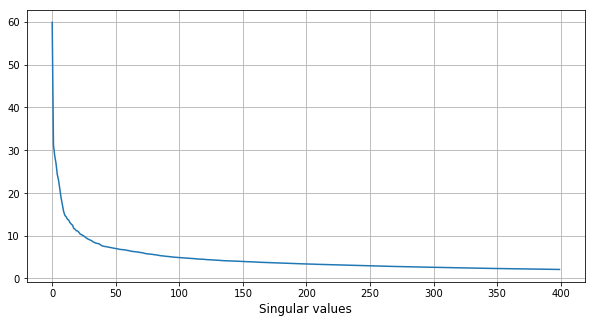

In [14]:
s = lsi.projection.s

import matplotlib.pyplot as plt
plt.figure(figsize=(10,5))
plt.plot(s[:500])
#plt.plot(np.cumsum(s[:500]), c='green')
plt.xlabel('Singular values', fontsize=12)
plt.grid(True, 'both')
plt.show()

In [9]:
import logging
logging.basicConfig(level=logging.INFO)
lsi.print_topics(20,30)

INFO:gensim.models.lsimodel:topic #0(59.852): 0.259*"неустойк" + 0.234*"услуг" + 0.182*"энерг" + 0.167*"товар" + 0.153*"работ" + 0.145*"2016" + 0.127*"год" + 0.121*"средств" + 0.119*"пен" + 0.103*"организац" + 0.102*"ден" + 0.100*"фактическ" + 0.100*"поставк" + 0.100*"просрочк" + 0.099*"заказчик" + 0.095*"04" + 0.094*"05" + 0.092*"06" + 0.091*"имуществ" + 0.089*"кредитор" + 0.084*"02" + 0.083*"счет" + 0.082*"процент" + 0.082*"08" + 0.082*"покупател" + 0.082*"09" + 0.081*"выполнен" + 0.078*"обяз" + 0.076*"плат" + 0.076*"стоимост"
INFO:gensim.models.lsimodel:topic #1(31.229): -0.556*"энерг" + 0.310*"работ" + -0.202*"электрическ" + 0.190*"товар" + -0.175*"потреблен" + -0.175*"теплов" + -0.161*"организац" + 0.161*"выполнен" + 0.144*"заказчик" + -0.142*"потребител" + -0.135*"фактическ" + -0.132*"абонент" + -0.106*"ден" + -0.102*"коммунальн" + -0.101*"сет" + 0.093*"подрядчик" + 0.090*"средств" + -0.084*"энергоснабжен" + -0.084*"прибор" + -0.083*"мощност" + -0.078*"месяц" + 0.077*"контракт" +

INFO:gensim.models.lsimodel:topic #14(13.032): 0.410*"теплов" + -0.284*"электрическ" + -0.279*"ден" + 0.242*"контракт" + -0.206*"пен" + -0.175*"фактическ" + -0.172*"дня" + 0.163*"энерг" + -0.158*"наступлен" + 0.134*"неустойк" + -0.131*"газ" + 0.108*"теплоснабжен" + 0.105*"груз" + -0.101*"дне" + 0.100*"теплоносител" + 0.095*"средств" + -0.094*"календарн" + 0.092*"пользован" + -0.089*"ставк" + -0.087*"просрочк" + -0.085*"банк" + -0.084*"рефинансирован" + -0.084*"2016" + 0.080*"последств" + 0.080*"вод" + 0.079*"горяч" + -0.078*"начин" + -0.076*"электроэнерг" + 0.075*"333" + 0.074*"процент"
INFO:gensim.models.lsimodel:topic #15(12.696): 0.340*"груз" + 0.326*"вагон" + -0.302*"организац" + -0.242*"2016" + -0.205*"взнос" + -0.189*"член" + 0.169*"перевозк" + -0.163*"саморегулируем" + 0.146*"железнодорожн" + 0.139*"газ" + -0.139*"членск" + 0.119*"перевозчик" + 0.111*"пен" + -0.110*"некоммерческ" + -0.110*"товар" + 0.100*"ремонт" + -0.098*"страхов" + -0.094*"ассоциац" + -0.093*"арендн" + 0.086*"

[(0,
  '0.259*"неустойк" + 0.234*"услуг" + 0.182*"энерг" + 0.167*"товар" + 0.153*"работ" + 0.145*"2016" + 0.127*"год" + 0.121*"средств" + 0.119*"пен" + 0.103*"организац" + 0.102*"ден" + 0.100*"фактическ" + 0.100*"поставк" + 0.100*"просрочк" + 0.099*"заказчик" + 0.095*"04" + 0.094*"05" + 0.092*"06" + 0.091*"имуществ" + 0.089*"кредитор" + 0.084*"02" + 0.083*"счет" + 0.082*"процент" + 0.082*"08" + 0.082*"покупател" + 0.082*"09" + 0.081*"выполнен" + 0.078*"обяз" + 0.076*"плат" + 0.076*"стоимост"'),
 (1,
  '-0.556*"энерг" + 0.310*"работ" + -0.202*"электрическ" + 0.190*"товар" + -0.175*"потреблен" + -0.175*"теплов" + -0.161*"организац" + 0.161*"выполнен" + 0.144*"заказчик" + -0.142*"потребител" + -0.135*"фактическ" + -0.132*"абонент" + -0.106*"ден" + -0.102*"коммунальн" + -0.101*"сет" + 0.093*"подрядчик" + 0.090*"средств" + -0.084*"энергоснабжен" + -0.084*"прибор" + -0.083*"мощност" + -0.078*"месяц" + 0.077*"контракт" + -0.076*"вод" + 0.069*"процент" + 0.069*"результат" + -0.066*"пен" + -0.0

In [10]:
idx = 5204
print(data_samples[idx])
doc = corpus_tfidf[idx]
vec_lsi = lsi[doc] # convert the vector to LSI space
sims = index[vec_lsi] # perform a similarity vector against the corpus
most_similar = np.argsort(-sims)[1:]
print()
print(most_similar[0])
print()
print(data_samples[most_similar[0]])

Ассоциация ведущих арбитражных управляющих «Достояние» (далее – Истец, Ассоциация) обратилась в суд с исковым заявлением к арбитражному управляющему Козьмиди Аристиду Кузьмичу (далее – Ответчик) о взыскании задолженности по оплате дополнительного взноса в компенсационный фонд в размере SUM, и задолженности по оплате членских взносов за период с апреля 2016 по 13.04.2018 в размере SUM.
Определением от 16.08.2018 исковое заявление было принято к производству, предварительное и судебное заседания назначены на 12.10.2018.
Определением от 11.10.2018 судебное заседание было отложено на 14.11.2018 в связи с болезнью судьи.
В судебное заседание 14.11.2018 Ответчик, извещенный надлежащим образом о времени и месте судебного заседания не явился, своих представителей не направил.
В соответствии с пунктом 3 статьи 156 АПК РФ при неявке в судебное заседание арбитражного суда истца и (или) ответчика, надлежащим образом извещенных о времени и месте судебного разбирательства, суд вправе рассмотреть дел

In [11]:
tf = sorted(corpus_tfidf[idx], key=lambda x:x[1], reverse=True)[:50]
print(list(map(lambda t: (dictionary[t[0]], t[1]), tf)))

print()

tf_m = sorted(corpus_tfidf[most_similar[0]], key=lambda x:x[1], reverse=True)[:50]
print(list(map(lambda t: (dictionary[t[0]], t[1]), tf_m)))

[('организац', 0.4083126169891915), ('взнос', 0.3905598945114006), ('член', 0.3195490046002369), ('ассоциац', 0.284043559644655), ('некоммерческ', 0.266290837166864), ('партнерств', 0.1952799472557003), ('саморегулируем', 0.15977450230011844), ('федеральн', 0.15977450230011844), ('управля', 0.1420217798223275), ('устав', 0.1420217798223275), ('членск', 0.1420217798223275), ('ежемесячн', 0.12426905734453655), ('единовремен', 0.12426905734453655), ('04', 0.10651633486674562), ('документ', 0.10651633486674562), ('деятельн', 0.10651633486674562), ('поступлен', 0.10651633486674562), ('решен', 0.08876361238895468), ('совет', 0.08876361238895468), ('банкротств', 0.08876361238895468), ('членств', 0.08876361238895468), ('14', 0.07101088991116375), ('профессиональн', 0.07101088991116375), ('имуществ', 0.07101088991116375), ('26', 0.07101088991116375), ('уплачива', 0.07101088991116375), ('источник', 0.07101088991116375), ('регулярн', 0.07101088991116375), ('формирован', 0.07101088991116375), ('02

In [13]:
sorted(sims, reverse=True)[:50]

[1.0,
 0.9144218,
 0.90630114,
 0.892838,
 0.8876095,
 0.87976706,
 0.87901235,
 0.87850916,
 0.8777498,
 0.8767438,
 0.87469506,
 0.87201643,
 0.87059724,
 0.8690231,
 0.8686278,
 0.86848295,
 0.86847556,
 0.8680514,
 0.86776567,
 0.8668783,
 0.86329687,
 0.86137694,
 0.86079144,
 0.85988617,
 0.8589156,
 0.8564124,
 0.8509997,
 0.8501146,
 0.8496746,
 0.8492484,
 0.8456943,
 0.8429325,
 0.84284806,
 0.84150517,
 0.8411841,
 0.840686,
 0.83879447,
 0.8383908,
 0.8382524,
 0.8381691,
 0.8343123,
 0.83363795,
 0.832708,
 0.83267134,
 0.83219165,
 0.83098996,
 0.8289981,
 0.82878804,
 0.82780355,
 0.82773167]

In [ ]:
class StemmedCountVectorizer(CountVectorizer):
    def build_analyzer(self):
        analyzer = super(StemmedCountVectorizer, self).build_analyzer()
        return lambda doc: ([CACHE[w] for w in analyzer(doc) if w not in STOP_WORDS])


class StemmedTfidfVectorizer(TfidfVectorizer):
    def build_analyzer(self):
        analyzer = super(StemmedTfidfVectorizer, self).build_analyzer()
        return lambda doc: ([CACHE[w] for w in analyzer(doc) if w not in STOP_WORDS])


# Use tf-idf features for NMF.
print("Extracting tf-idf features for NMF...")
tfidf_vectorizer = StemmedTfidfVectorizer(max_df=0.9, min_df=2,
                                   max_features=n_features,
                                   stop_words=None)
t0 = time()
tfidf = tfidf_vectorizer.fit_transform(data_samples)
print("done in %0.3fs." % (time() - t0))

# Use tf (raw term count) features for LDA.
print("Extracting tf features for LDA...")
tf_vectorizer = StemmedCountVectorizer(max_df=0.9, min_df=2,
                                max_features=n_features,
                                stop_words=None)
t0 = time()
tf = tf_vectorizer.fit_transform(data_samples)
print("done in %0.3fs." % (time() - t0))
print()

# Fit the NMF model
print("Fitting the NMF model (Frobenius norm) with tf-idf features, "
      "n_samples=%d and n_features=%d..."
      % (n_samples, n_features))
t0 = time()
nmf = NMF(n_components=n_components, random_state=1,
          alpha=.1, l1_ratio=.5).fit(tfidf)
print("done in %0.3fs." % (time() - t0))

print("\nTopics in NMF model (Frobenius norm):")
tfidf_feature_names = tfidf_vectorizer.get_feature_names()
print_top_words(nmf, tfidf_feature_names, n_top_words)

# Fit the NMF model
print("Fitting the NMF model (generalized Kullback-Leibler divergence) with "
      "tf-idf features, n_samples=%d and n_features=%d..."
      % (n_samples, n_features))
t0 = time()
nmf = NMF(n_components=n_components, random_state=1,
          beta_loss='kullback-leibler', solver='mu', max_iter=1000, alpha=.1,
          l1_ratio=.5).fit(tfidf)
print("done in %0.3fs." % (time() - t0))

print("\nTopics in NMF model (generalized Kullback-Leibler divergence):")
tfidf_feature_names = tfidf_vectorizer.get_feature_names()
print_top_words(nmf, tfidf_feature_names, n_top_words)

print("Fitting LDA models with tf features, "
      "n_samples=%d and n_features=%d..."
      % (n_samples, n_features))
lda = LatentDirichletAllocation(n_components=n_components, max_iter=5,
                                learning_method='online',
                                learning_offset=50.,
                                random_state=0)
t0 = time()
lda.fit(tf)
print("done in %0.3fs." % (time() - t0))

print("\nTopics in LDA model:")
tf_feature_names = tf_vectorizer.get_feature_names()
print_top_words(lda, tf_feature_names, n_top_words)